## Questions to be investigated:

- Is home ground advantage a thing?
- Which teams have the strongest home ground advantage?
- Does home ground referee bias exsist?

In [1]:
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Acquiring Data

In [2]:
def grab_epl_data():
    # Connect to football-data.co.uk
    res = requests.get("https://www.football-data.co.uk/englandm.php")

    # Create a BeautifulSoup object
    soup = BeautifulSoup(res.content, 'lxml')

    # Find the tables with the links to the data in them.
    table = soup.find_all('table', {'align': 'center', 'cellspacing': '0', 'width': '800'})[1]
    body = table.find_all('td', {'valign': 'top'})[1]

    # Grab the urls for the csv files
    links = [link.get('href') for link in body.find_all('a')]
    links_text = [link_text.text for link_text in body.find_all('a')]

    data_urls = []

    # Create a list of links
    prefix = 'https://www.football-data.co.uk/'
    for i, text in enumerate(links_text):
        if text == 'Premier League':
            data_urls.append(prefix + links[i])

    # Get rid of last 11 uls as these don't include match stats and odds, and we
    # only want from 2005 onwards
    data_urls = data_urls[:-13]

    df = pd.DataFrame()

    # Iterate over the urls
    for url in data_urls:
        # Get the season and make it a column
        season = url.split('/')[4]

        print(f"Getting data for season {season}")

        # Read the data from the url into a DataFrame
        temp_df = pd.read_csv(url)
        temp_df['season'] = season

        # Create helpful columns like Day, Month, Year, Date etc. so that our data is clean
        temp_df = (temp_df.dropna(axis='columns', thresh=temp_df.shape[0]-30)
                          .assign(Day=lambda df: df.Date.str.split('/').str[0],
                                  Month=lambda df: df.Date.str.split('/').str[1],
                                  Year=lambda df: df.Date.str.split('/').str[2])
                          .assign(Date=lambda df: df.Month + '/' + df.Day + '/' + df.Year)
                          .assign(Date=lambda df: pd.to_datetime(df.Date))
                          .dropna())

        # Append the temp_df to the main df
        df = df.append(temp_df, sort=True)

    # Drop all NAs
    df = df.dropna(axis=1).dropna().sort_values(by='Date')
    print("Finished grabbing data.")

    return df

In [3]:
df = grab_epl_data()
df.to_csv("epl_data.csv", index=False)   

Getting data for season 2324
Getting data for season 2223
Getting data for season 2122
Getting data for season 2021
Getting data for season 1920
Getting data for season 1819
Getting data for season 1718
Getting data for season 1617
Getting data for season 1516
Getting data for season 1415
Getting data for season 1314
Getting data for season 1213
Getting data for season 1112
Getting data for season 1011
Getting data for season 0910
Getting data for season 0809
Getting data for season 0708
Getting data for season 0607
Finished grabbing data.


# Data Exploration
Looking at home team win rate since 2005 to see if there is a trend.

In [126]:
df.tail(5)

,AC,AF,AR,AS,AST,AY,AwayTeam,B365A,B365D,B365H,BWA,BWD,BWH,Date,Day,Div,FTAG,FTHG,FTR,HC,HF,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,Month,Referee,VCA,VCD,VCH,Year,season,homeWin,draw,awayWin
54,4.0,19.0,0.0,13.0,5.0,4.0,Tottenham,4.33,4.33,1.67,4.20,4.20,1.72,2023-09-24,24,E0,2.0,2.0,D,11.0,12.0,0.0,13.0,6.0,1.0,1.0,D,3.0,Arsenal,4.40,4.3,1.70,09,R Jones,4.6,4.10,1.65,2023,2324,0,1,0
55,4.0,17.0,0.0,12.0,4.0,3.0,Bournemouth,7.50,5.25,1.36,7.25,5.50,1.36,2023-09-24,24,E0,1.0,3.0,H,4.0,12.0,0.0,13.0,4.0,1.0,1.0,D,3.0,Brighton,7.00,5.5,1.40,09,J Brooks,8.0,5.25,1.33,2023,2324,1,0,0
56,11.0,11.0,0.0,15.0,7.0,3.0,Aston Villa,3.80,3.75,1.91,3.80,3.80,1.88,2023-09-24,24,E0,1.0,0.0,A,5.0,9.0,0.0,10.0,4.0,0.0,0.0,D,2.0,Chelsea,3.80,3.8,1.90,09,J Gillett,3.8,3.70,1.87,2023,2324,0,0,1
57,4.0,13.0,0.0,11.0,4.0,2.0,West Ham,7.00,5.00,1.40,6.75,5.25,1.39,2023-09-24,24,E0,1.0,3.0,H,7.0,12.0,0.0,22.0,7.0,1.0,1.0,D,0.0,Liverpool,6.75,5.5,1.40,09,C Kavanagh,7.5,5.00,1.36,2023,2324,1,0,0
58,6.0,8.0,0.0,22.0,15.0,0.0,Newcastle,1.44,4.75,7.00,1.44,4.60,6.75,2023-09-24,24,E0,8.0,0.0,A,2.0,12.0,0.0,9.0,1.0,3.0,0.0,A,3.0,Sheffield United,1.45,4.7,6.75,09,S Attwell,1.4,4.60,7.50,2023,2324,0,0,1


In [88]:
print(sorted(df['HomeTeam'].unique().tolist()))

['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brentford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leeds', 'Leicester', 'Liverpool', 'Luton', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', "Nott'm Forest", 'Portsmouth', 'QPR', 'Reading', 'Sheffield United', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


In [5]:
# Create Home, Draw and Away Win columns
df = df.assign(homeWin=lambda df: df.apply(lambda row: 1 if row.FTHG > row.FTAG else 0, axis='columns'),
              draw=lambda df: df.apply(lambda row: 1 if row.FTHG == row.FTAG else 0, axis='columns'),
              awayWin=lambda df: df.apply(lambda row: 1 if row.FTHG < row.FTAG else 0, axis='columns'))


### Home Ground Edge

In [6]:
win_rates = \
(df.groupby('season')
    .mean()
    .loc[:, ['homeWin', 'draw', 'awayWin']])

win_rates

,homeWin,draw,awayWin
season,,,
0607,0.477573,0.258575,0.263852
0708,0.463158,0.263158,0.273684
0809,0.453826,0.255937,0.290237
0910,0.507895,0.252632,0.239474
1011,0.471053,0.292105,0.236842
1112,0.450000,0.244737,0.305263
1213,0.433862,0.285714,0.280423
1314,0.472973,0.208108,0.318919
1415,0.453826,0.245383,0.300792


In [7]:
average_win_rates = df[['homeWin', 'draw', 'awayWin']].mean()

average_win_rates_df = pd.DataFrame(average_win_rates, columns=['Average'])

print(average_win_rates_df)

          Average
homeWin  0.456676
draw     0.245760
awayWin  0.297564


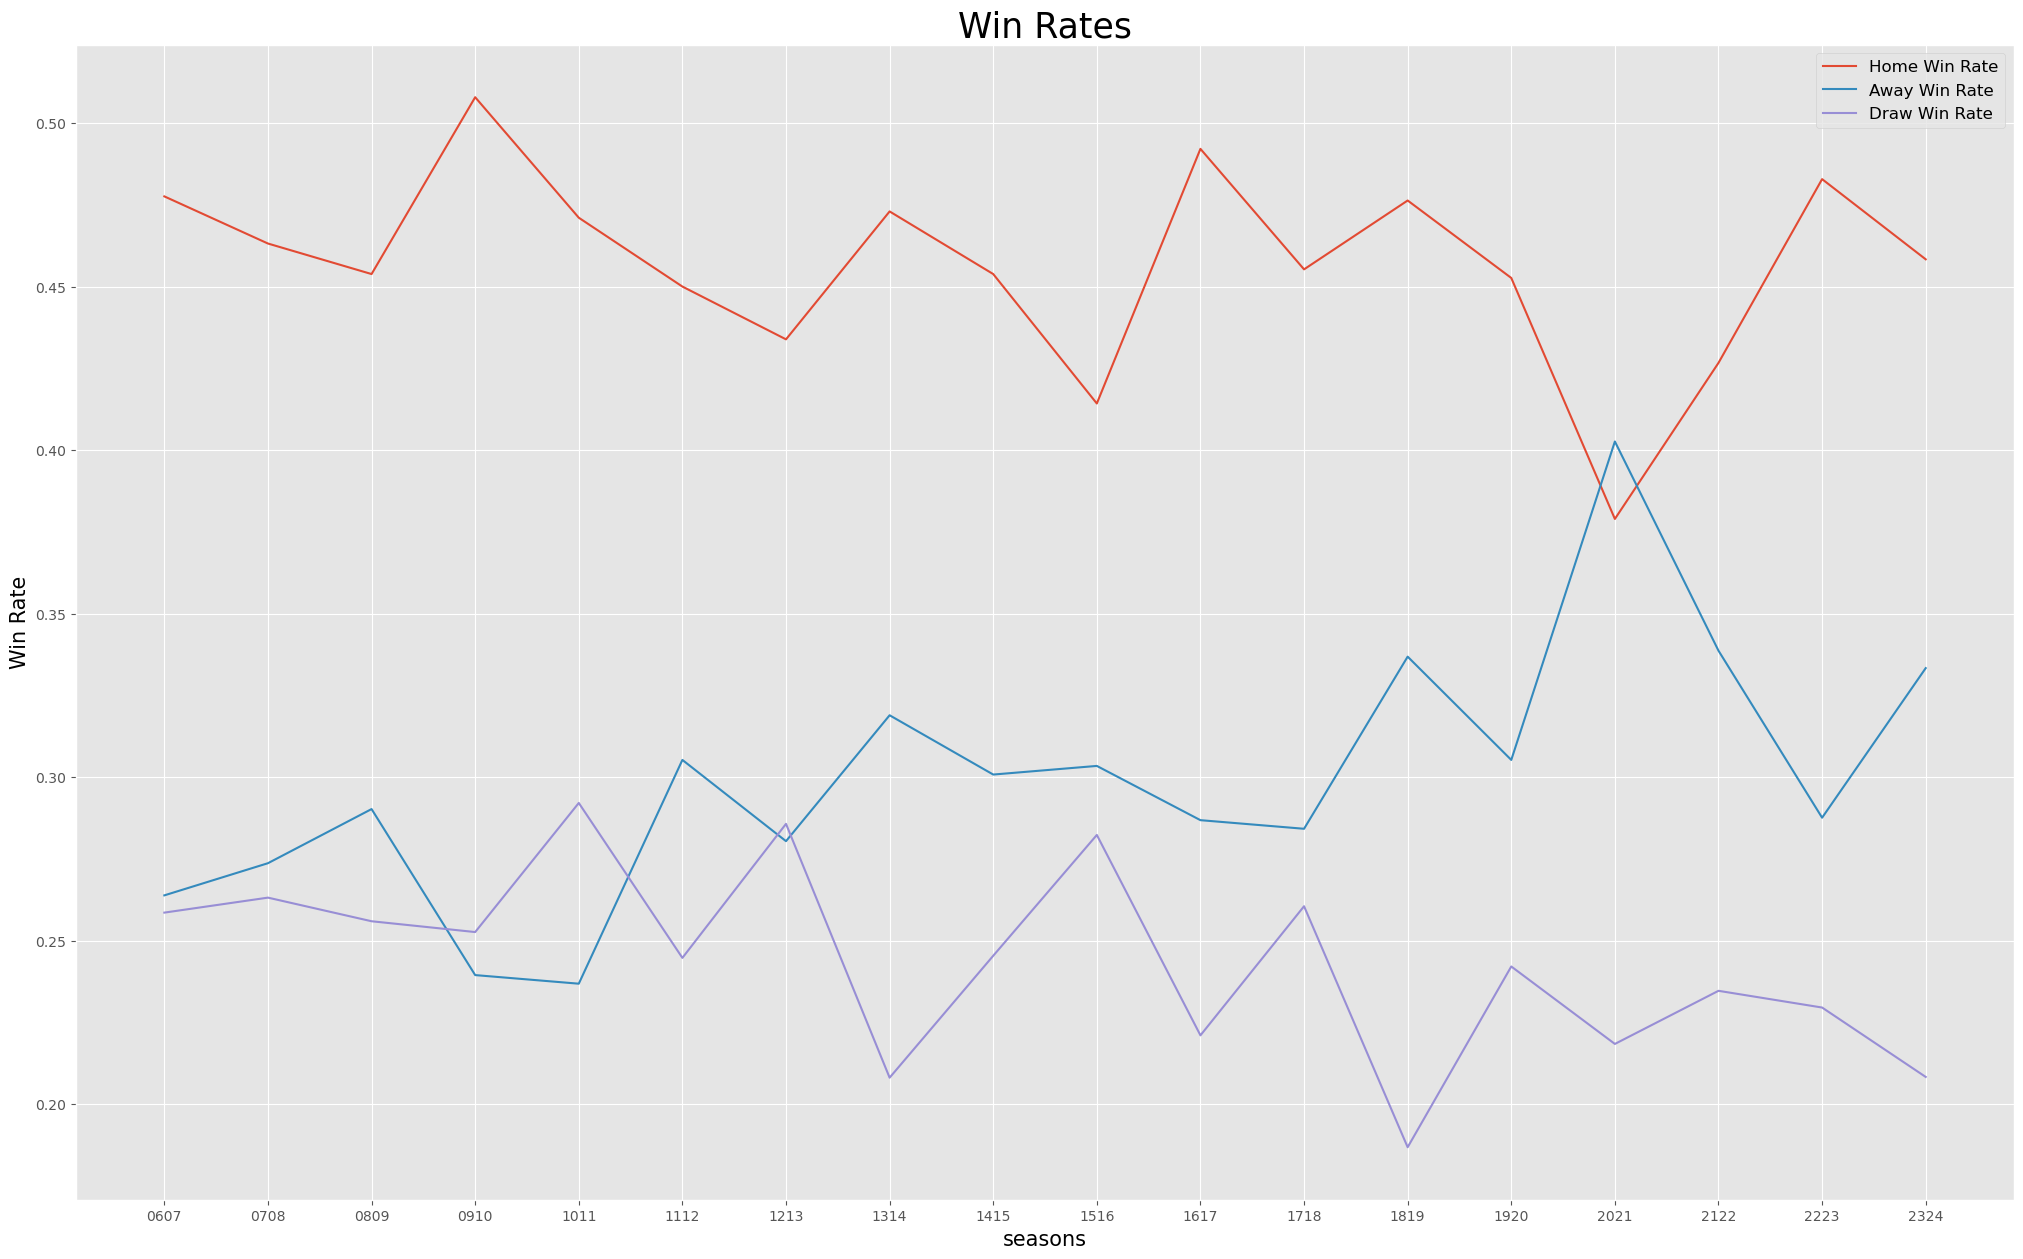

In [8]:
# Set the style
plt.style.use('ggplot')

fig_width = 25  
fig_height = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

#fig = plt.figure()
#ax = fig.add_subplot(111)

home_line = ax.plot(win_rates.homeWin, label='Home Win Rate')
away_line = ax.plot(win_rates.awayWin, label='Away Win Rate')
draw_line = ax.plot(win_rates.draw, label='Draw Win Rate')
ax.set_xlabel("seasons", fontsize=15)
ax.set_ylabel("Win Rate", fontsize=15)
plt.title("Win Rates", fontsize=25)
plt.legend(loc='upper right', fontsize='large')

#### Discoveries

Win rates for home teams if fairly consistent at around 46%, draws occur at around 30% of the time and away teams win around 24% of the time. There are expertions like the 2021 season. There is a steady increase in away win, with draws decreasing over the same period.

Let's now look at the home game agvantage (HGA). We can then take a look at the top 6 EPL clubs.

In [9]:
home_win_rates = \
(df.groupby(['HomeTeam'])
    .homeWin
    .mean())

away_win_rates = \
(df.groupby(['AwayTeam'])
    .awayWin
    .mean())

hga = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HGA'}).sort_values(by='HGA', ascending=False)

In [141]:
hga.head(20)

,HomeTeam,HGA
28,Nott'm Forest,0.337662
11,Charlton,0.315789
34,Stoke,0.241131
25,Middlesbrough,0.236842
31,Reading,0.234962
16,Fulham,0.221981
37,Tottenham,0.219157
23,Man City,0.218247
32,Sheffield United,0.214124
15,Everton,0.213818


Nottingham Forest has the best HGA followed by Fulham. Let's see how the HGA for big 6 compare over seasons. 

In [11]:
big_6 = ['Arsenal', 'Liverpool', 'Man City', 'Man United', 'Chelsea', 'Tottenham']
homewin_rates_6 = df[df.HomeTeam.isin(big_6)].groupby(['HomeTeam', 'season']).homeWin.mean()
awaywin_rates_6 = df[df.AwayTeam.isin(big_6)].groupby(['AwayTeam', 'season']).awayWin.mean()

hga_top_6 = homewin_rates_6 - awaywin_rates_6

hga_top_6.unstack(level=0)

HomeTeam,Arsenal,Chelsea,Liverpool,Man City,Man United,Tottenham
season,,,,,,
0607,0.263158,0.000000,0.421053,-0.052632,0.105263,0.368421
0708,0.210526,-0.052632,0.157895,0.368421,0.368421,0.263158
0809,0.105263,-0.157895,-0.052632,0.578947,0.210526,0.315789
0910,0.368421,0.368421,0.421053,0.315789,0.263158,0.368421
1011,0.157895,0.368421,0.368421,0.263158,0.684211,0.105263
1112,0.157895,0.315789,-0.105263,0.421053,0.105263,0.315789
1213,0.052632,0.105263,0.105263,0.248538,0.201754,0.052632
1314,0.143275,0.251462,0.307018,0.362573,-0.026316,0.078947
1415,0.131579,0.210526,0.105263,0.210526,0.421053,0.052632


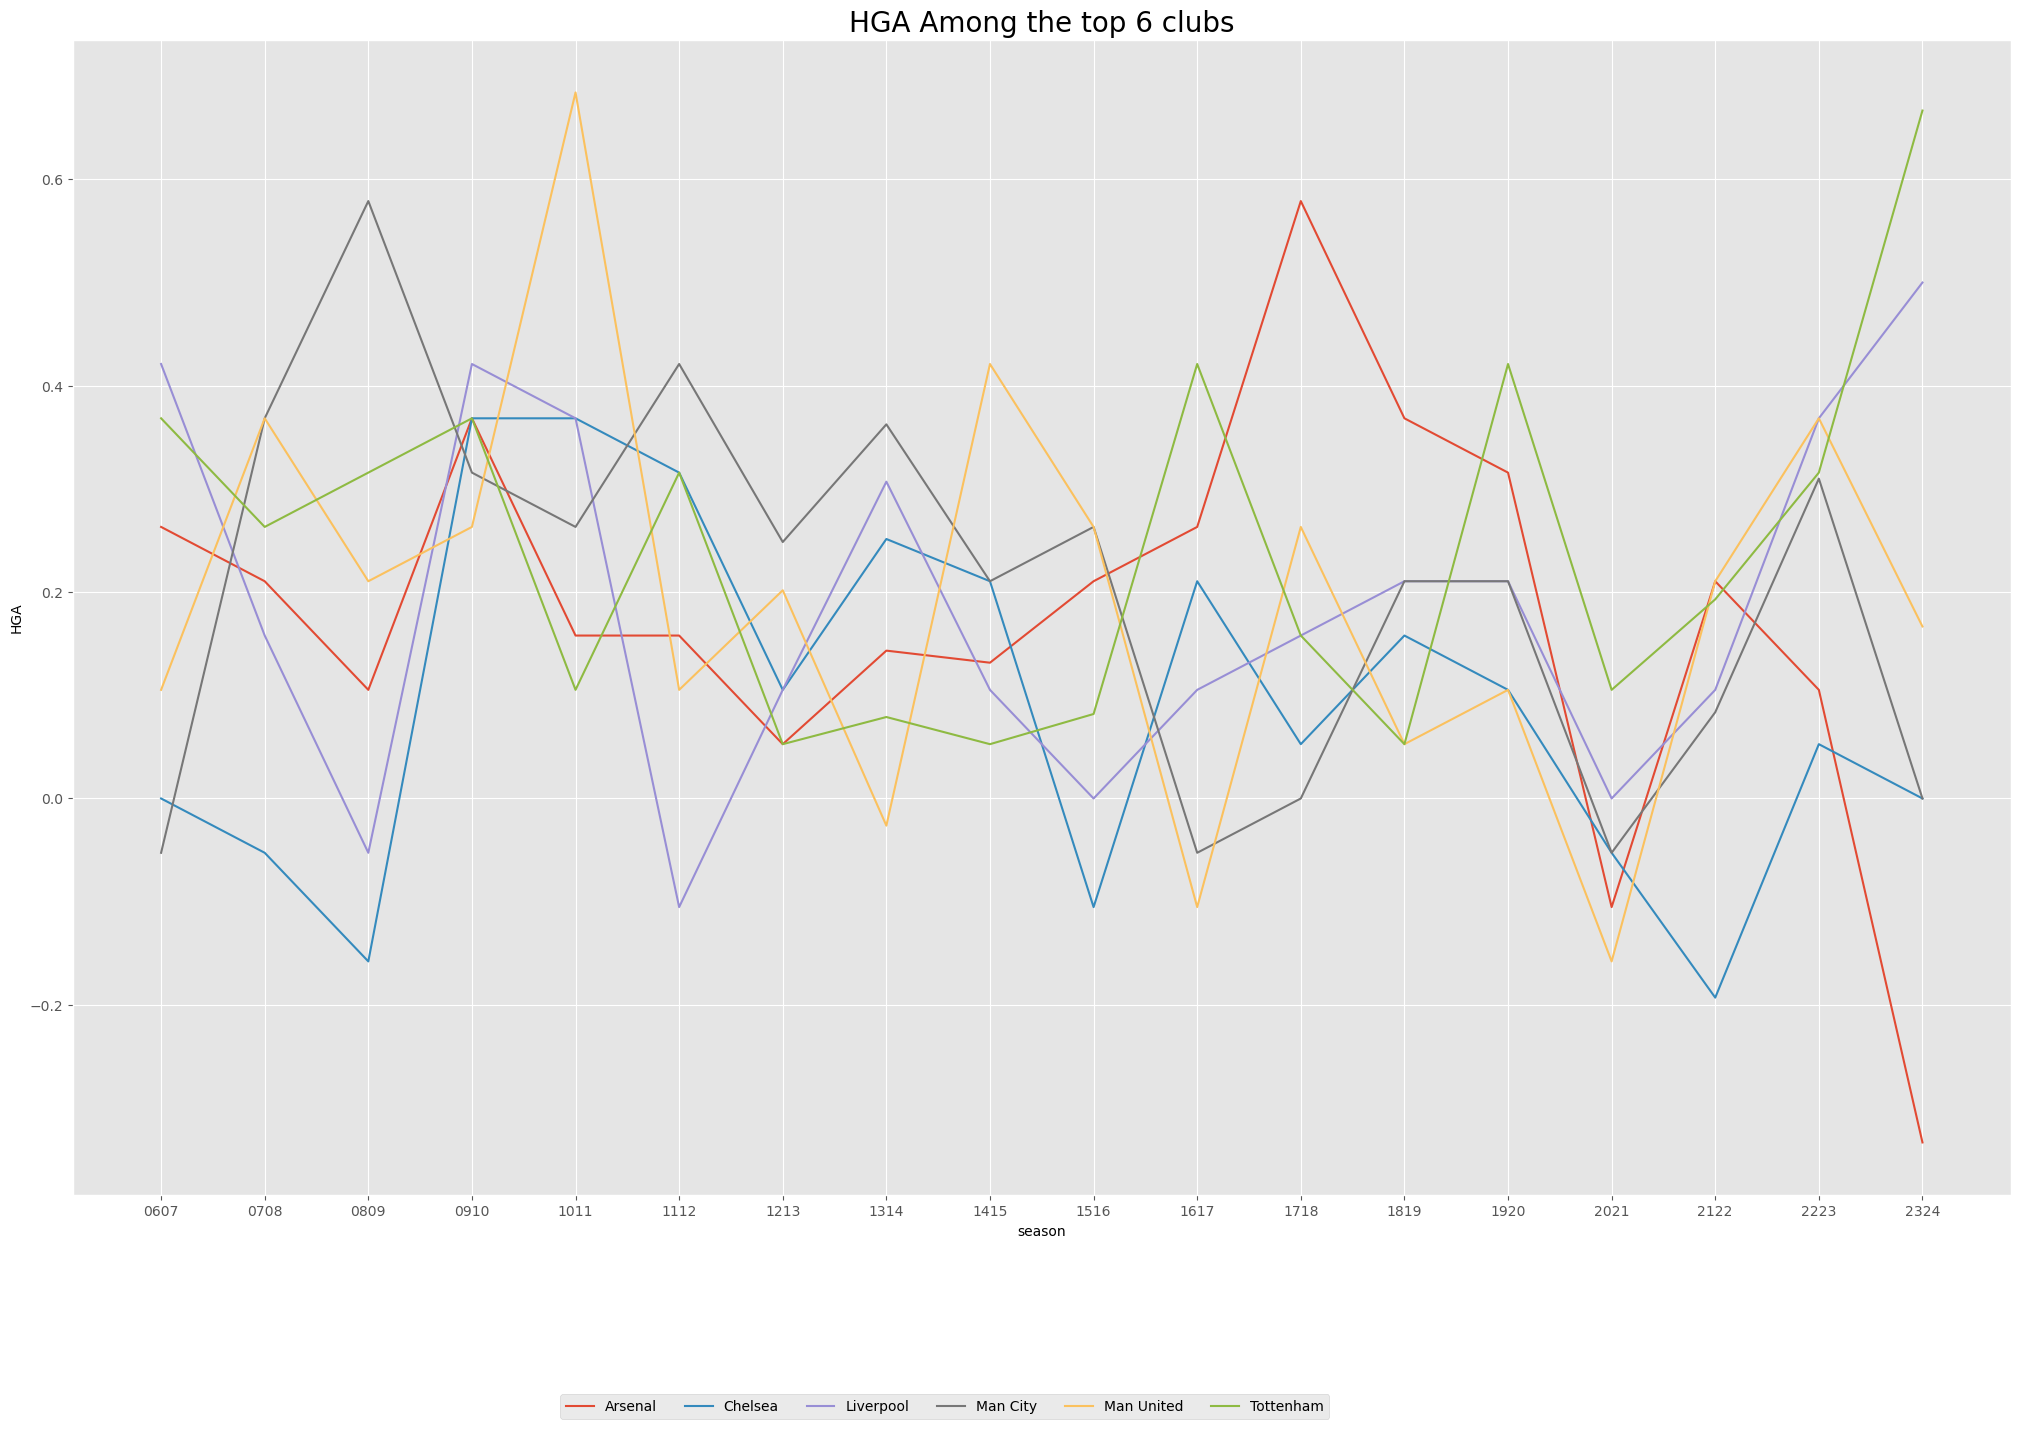

In [12]:
fig_width = 25  
fig_height = 15
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

sns.lineplot(x='season', y='HGA', hue='team', data=hga_top_6.reset_index().rename(columns={0: 'HGA', 'HomeTeam': 'team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.2))
plt.title("HGA Among the top 6 clubs", fontsize=20)
plt.show()

This graph is quite chaotic but we can still see that at some point in time all the big 6 have had a HGA below 0. The 2324 season has just started so this has skewed the HGA of Arsenal in the latest season. 

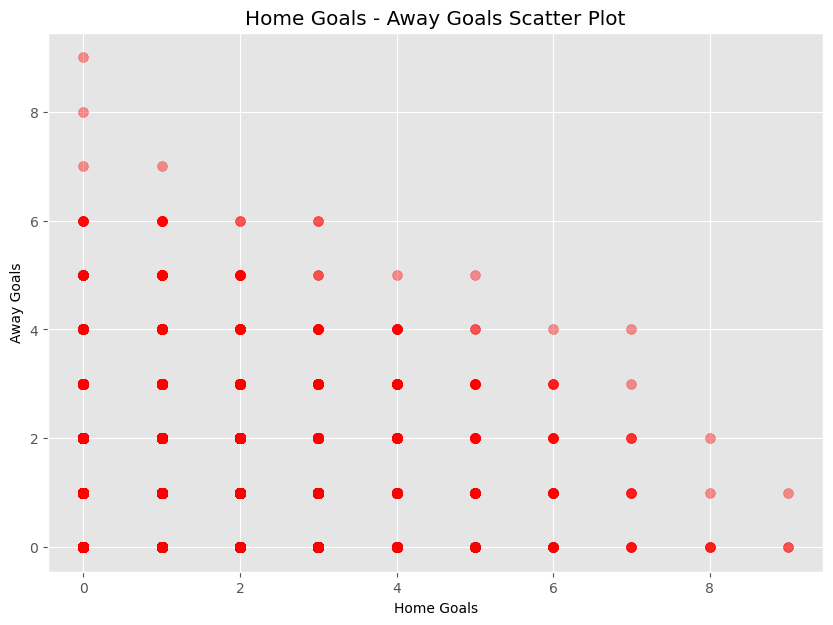

In [128]:
df.plot(kind ="scatter", x="FTHG",y="FTAG", alpha =0.4, color="red", figsize=(10, 7), s=50)
plt.xlabel("Home Goals")
plt.ylabel("Away Goals")
plt.title("Home Goals - Away Goals Scatter Plot")
plt.show()

This scatter plot shows in basic terms that if a home team score more than 4 goals they are highly likey to win the game and when an away team score more than 5 goals they are most likely to win the game. This is a crude representation and requires further investigation but fot this project this will suffice. 

## Referee Bias

As a football fan we think that that certain referee's have a bias when playing in certain games. Exploring referee bias for referee's for the top 10 Referee's based on games may be of interest.

In [74]:
print('Overall Home Win Rate: {:.4}%'.format(df.homeWin.mean() * 100))
print('Overall Draw Rate: {:.4}%'.format(df.draw.mean() * 100))
print('Overall Away Win Rate: {:.4}%'.format(df.awayWin.mean() * 100))


top_20_refs = df.Referee.value_counts().head(20).index

homewin_rates = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).homeWin.mean()
draw_rates = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).draw.mean()
awaywin_rates = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).awayWin.mean()
games_officiated = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).size()

referee_percentages = pd.DataFrame({'Home Win Rate': homewin_rates,
                                    'Draw Rate': draw_rates,
                                    'Away Win Rate': awaywin_rates,
                                    'Games Officiated': games_officiated})
                                    
referee_percentages_sorted = referee_percentages.sort_values(by='Home Win Rate', ascending=False)

referee_percentages_sorted

Overall Home Win Rate: 45.67%
Overall Draw Rate: 24.58%
Overall Away Win Rate: 29.76%


,Home Win Rate,Draw Rate,Away Win Rate,Games Officiated
Referee,,,,
L Mason,0.508834,0.233216,0.257951,283
C Foy,0.495098,0.215686,0.289216,204
L Probert,0.483516,0.236264,0.280220,182
M Clattenburg,0.478764,0.258687,0.262548,259
P Dowd,0.477876,0.269912,0.252212,226
M Jones,0.475248,0.262376,0.262376,202
H Webb,0.463830,0.268085,0.268085,235
S Attwell,0.462366,0.279570,0.258065,186
M Atkinson,0.461009,0.222477,0.316514,436


Overall Home Win Rate: 45.67% and Overall Away Win Rate: 29.76%. L Mason seems to be the most influenced by the home crowd with the most home wins and least away wins. Others referee's show a similar pattern with high home win rate compared to low away wins such as M Clattenburg, M Atkinson, etc. 
This may not be a bias these referee's may just be playing in games where the home team is a big club meaning they are more likely to win games at home in the first place. 

In [133]:
filtered_df = df[(df.HomeTeam == 'Arsenal') | (df.HomeTeam == 'Liverpool') | (df.HomeTeam == 'Chelsea') 
                 | (df.HomeTeam == 'Man City') | (df.HomeTeam == 'Man United') | (df.HomeTeam == 'Tottenham')]

print('Overall Home Win Rate: {:.4}%'.format(filtered_df.homeWin.mean() * 100))
print('Overall Draw Rate: {:.4}%'.format(filtered_df.draw.mean() * 100))
print('Overall Away Win Rate: {:.4}%'.format(filtered_df.awayWin.mean() * 100))

top_20_refs = filtered_df.Referee.value_counts().head(20).index

homewin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).homeWin.mean()
draw_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).draw.mean()
awaywin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).awayWin.mean()
games_officiated = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).size()

referee_percentages = pd.DataFrame({'Home Win Rate': homewin_rates,
                                    'Draw Rate': draw_rates,
                                    'Away Win Rate': awaywin_rates,
                                    'Games Officiated': games_officiated})

referee_percentages_sorted = referee_percentages.sort_values(by='Home Win Rate', ascending=False)

referee_percentages_sorted

Overall Home Win Rate: 65.81%
Overall Draw Rate: 20.1%
Overall Away Win Rate: 14.09%


,Home Win Rate,Draw Rate,Away Win Rate,Games Officiated
Referee,,,,
C Foy,0.803571,0.107143,0.089286,56
L Mason,0.772152,0.164557,0.063291,79
J Moss,0.717391,0.130435,0.152174,92
K Friend,0.680000,0.213333,0.106667,75
P Dowd,0.675676,0.216216,0.108108,74
M Jones,0.671429,0.257143,0.071429,70
A Wiley,0.666667,0.238095,0.095238,42
H Webb,0.666667,0.197531,0.135802,81
L Probert,0.666667,0.153846,0.179487,39


The dataframe above shows where the top 20 referees officiated games for the big 6 teams in the EPL. We see the overall Home Win Rate has increased to 65.81% while the overall Away Win Rate is down to 14.09%. This concludes that the quality of the teams especially the big 6 has an impact on the result of the game. But this doesn't take from the fact that referees may be bias.

In [113]:
big_6 = ['Arsenal', 'Liverpool', 'Chelsea', 'Man City', 'Man United', 'Tottenham'] 

filtered_df = df[df.HomeTeam.isin(big_6) == False]

print('Overall Home Win Rate: {:.4}%'.format(filtered_df.homeWin.mean() * 100))
print('Overall Draw Rate: {:.4}%'.format(filtered_df.draw.mean() * 100))
print('Overall Away Win Rate: {:.4}%'.format(filtered_df.awayWin.mean() * 100))

top_20_refs = filtered_df.Referee.value_counts().head(20).index

homewin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).homeWin.mean()
draw_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).draw.mean()
awaywin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).awayWin.mean()
games_officiated = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).size()

referee_percentages = pd.DataFrame({'Home Win Rate': homewin_rates,
                                    'Draw Rate': draw_rates,
                                    'Away Win Rate': awaywin_rates,
                                    'Games Officiated': games_officiated})

referee_percentages_sorted = referee_percentages.sort_values(by='Home Win Rate', ascending=False)

referee_percentages_sorted

Overall Home Win Rate: 37.04%
Overall Draw Rate: 26.49%
Overall Away Win Rate: 36.47%


,Home Win Rate,Draw Rate,Away Win Rate,Games Officiated
Referee,,,,
L Probert,0.433566,0.258741,0.307692,143
M Clattenburg,0.414773,0.267045,0.318182,176
L Mason,0.406863,0.259804,0.333333,204
M Atkinson,0.388889,0.235294,0.375817,306
M Halsey,0.387755,0.234694,0.377551,98
P Dowd,0.381579,0.296053,0.322368,152
C Foy,0.378378,0.256757,0.364865,148
M Jones,0.371212,0.265152,0.363636,132
C Pawson,0.367470,0.246988,0.385542,166


This shows officiated games excluding the big 6. Overall win rate is down and Away win rate is up, both at around 37%. Thi further shows the quality of the team has a big impact on outcome of games which is obvious. But like any other sports fan will tell you referees are bias, so let investigate further by looking at the away record of the big 6 compared to the other teams. Thi will show us if there is a bias and if referees are influenced by the much larger home crowds. 

In [134]:
big_6 = ['Arsenal', 'Liverpool', 'Chelsea', 'Man City', 'Man United', 'Tottenham'] 

filtered_df = df[(df.AwayTeam.isin(big_6) == True)]

print('Overall Home Win Rate: {:.4}%'.format(filtered_df.homeWin.mean() * 100))
print('Overall Away Win Rate: {:.4}%'.format(filtered_df.awayWin.mean() * 100))

top_20_refs = filtered_df.Referee.value_counts().head(20).index

homewin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).homeWin.mean()
awaywin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).awayWin.mean()

referee_percentages = pd.DataFrame({'Home Win Rate': homewin_rates,
                                    'Away Win Rate': awaywin_rates})

referee_percentages_sorted = referee_percentages.sort_values(by='Home Win Rate', ascending=False)

referee_percentages_sorted

Overall Home Win Rate: 29.05%
Overall Away Win Rate: 47.4%


,Home Win Rate,Away Win Rate
Referee,,
H Webb,0.445783,0.349398
P Dowd,0.389610,0.363636
M Oliver,0.367188,0.390625
S Attwell,0.351351,0.378378
M Clattenburg,0.336957,0.423913
M Atkinson,0.325000,0.418750
A Marriner,0.296053,0.473684
A Wiley,0.292683,0.560976
A Taylor,0.289062,0.468750


In [136]:
big_6 = ['Arsenal', 'Liverpool', 'Chelsea', 'Man City', 'Man United', 'Tottenham'] 

filtered_df = df[(df.HomeTeam.isin(big_6) == False) | (df.AwayTeam.isin(big_6) == False)]

print('Overall Home Win Rate: {:.4}%'.format(filtered_df.homeWin.mean() * 100))
print('Overall Away Win Rate: {:.4}%'.format(filtered_df.awayWin.mean() * 100))

top_20_refs = filtered_df.Referee.value_counts().head(20).index

homewin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).homeWin.mean()
awaywin_rates = filtered_df[filtered_df.Referee.isin(top_20_refs)].groupby(['Referee']).awayWin.mean()

referee_percentages = pd.DataFrame({'Home Win Rate': homewin_rates,
                                    'Away Win Rate': awaywin_rates})

referee_percentages_sorted = referee_percentages.sort_values(by='Home Win Rate', ascending=False)

referee_percentages_sorted

Overall Home Win Rate: 45.38%
Overall Away Win Rate: 30.17%


,Home Win Rate,Away Win Rate
Referee,,
L Mason,0.505338,0.259786
C Foy,0.500000,0.288660
L Probert,0.483333,0.277778
M Clattenburg,0.482143,0.254464
M Jones,0.474747,0.267677
S Attwell,0.465909,0.255682
P Dowd,0.465686,0.259804
J Moss,0.457031,0.355469
K Friend,0.456274,0.311787


Big 6 away record is 47.4% while the other teams away win percentage is 30.17%. This is down from home reecord of 65.81% and 37.04% respectively. The drop in performance in far larger for the big 6 teams, one of the reason is going away from home is always harder. One of the reasons for this may be due the the crowds influence in the referees. 

Another way to see referee bias would be see the number of fouls made by the home and away teams and to see number of yellow and red card given. This could show us if refs are more lenient toward home team showing a bias.

In [147]:
print('Overall Home Team Foul Rate: {:.4}%'.format(filtered_df.HF.mean()))
print('Overall Away Team Foul Rate: {:.4}%'.format(filtered_df.AF.mean() ))
print('Overall Home Team Yellow Card Rate: {:.4}%'.format(filtered_df.HY.mean()))
print('Overall Away Team Yellow Card Rate: {:.4}%'.format(filtered_df.AY.mean()))
print('Overall Home Team Red Card Rate: {:.4}%'.format(filtered_df.HR.mean()))
print('Overall Away Team Red Card Rate: {:.4}%'.format(filtered_df.AR.mean()))



top_20_refs = df.Referee.value_counts().head(20).index

home_fouls = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).HF.mean()
home_yc = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).HY.mean()
home_rc = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).HR.mean()
away_fouls = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).AF.mean()
away_yc = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).AY.mean()
away_rc = df[df.Referee.isin(top_20_refs)].groupby(['Referee']).AR.mean()

referee_percentages = pd.DataFrame({'Home Team Fouls': home_fouls,
                                    'Home Team Yellow Card': home_yc,
                                    'Home Team Red Card': home_rc,
                                    'Away Team Fouls': away_fouls,
                                    'Away Team Yellow Card': away_yc,
                                    'Away Team Red Card': away_rc})
                                    
referee_percentages_sorted = referee_percentages.sort_values(by='Home Team Fouls', ascending=False)

referee_percentages_sorted


Overall Home Team Foul Rate: 10.78%
Overall Away Team Foul Rate: 11.2%
Overall Home Team Yellow Card Rate: 1.461%
Overall Away Team Yellow Card Rate: 1.741%
Overall Home Team Red Card Rate: 0.0576%
Overall Away Team Red Card Rate: 0.0777%


,Home Team Fouls,Home Team Yellow Card,Home Team Red Card,Away Team Fouls,Away Team Yellow Card,Away Team Red Card
Referee,,,,,,
H Webb,11.463830,1.502128,0.038298,12.034043,1.936170,0.068085
P Dowd,11.353982,1.411504,0.084071,12.557522,2.097345,0.123894
C Pawson,11.302632,1.684211,0.057018,11.482456,1.868421,0.083333
M Jones,11.168317,1.386139,0.034653,12.232673,1.782178,0.099010
M Clattenburg,11.081081,1.455598,0.108108,11.301158,1.810811,0.061776
P Tierney,11.037736,1.647799,0.056604,11.238994,1.754717,0.044025
M Dean,10.993377,1.827815,0.068433,11.088300,1.909492,0.130243
M Oliver,10.844633,1.497175,0.059322,11.002825,1.627119,0.070621
L Mason,10.812721,1.381625,0.049470,11.491166,1.699647,0.091873


As we can see from above there is a slight differnce between the home and away values, with the away rates being slightly higher some could say this is insignificant but I disagree. Even though the difference is small a yellow or red card can completely change the outcome of a game. Looking at H Webb he gives twice as many red cards to away teams than home. Ths pattern can be seen through all top 20 referees. We can now say that the referess are in some shape or form influenced by the home crowds.  

## Variable Correlation

Exploring different variables relationships with margin. We will firstly create a margin and then pick a few different variables to look at the correlations using a correlation heatmap.

The meaning of abbreviations: 
- FTHG = Full Time Home Team Goals
- FTAG = Full Time Away Team Goals
- AC = Away Team Corners
- AF = Away Team Fouls Committed
- AR = Away Team Red Cards
- AS = Away Team Shots
- AST = Away Team Shots on Target
- AY = Away Team Yellow Cards
- HC = Home Team Corners
- HF = Home Team Fouls Committed
- HR = Home Team Red Cards
- HS = Home Team Shots
- HST = Home Team Shots on Target
- HTR = Home Half Time Result
- HY = Home Team Yellow Cards

<Axes: >

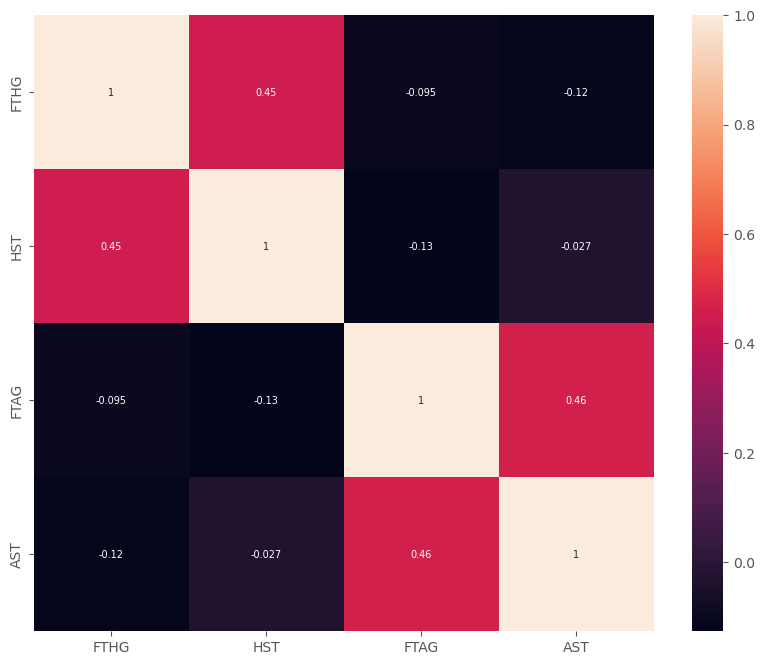

In [85]:
stat_cols = ['FTHG', 'HST', 'FTAG', 'AST']

stat_correlations = df[stat_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 7})

In [137]:
df['margin'] = df['FTHG'] - df['FTAG']

In [138]:
stat_cols = ['AC', 'AF', 'AR', 'AS', 'AST', 'AY', 'HC', 'HF', 'HR', 'HS', 'HST', 'HTR', 'HY', 'margin']

stat_correlations = df[stat_cols].corr()
stat_correlations['margin'].sort_values()

AST      -0.374858
AS       -0.324010
HY       -0.150292
HR       -0.129716
AC       -0.093408
HF       -0.052630
AF        0.004980
AY        0.016805
HC        0.089492
AR        0.101739
HS        0.299179
HST       0.401026
margin    1.000000
Name: margin, dtype: float64

<Axes: >

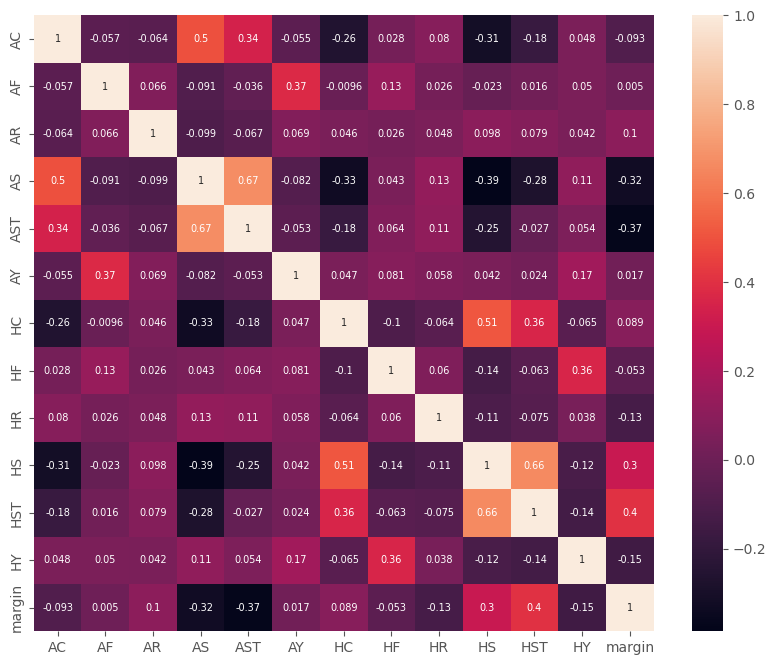

In [139]:
plt.figure(figsize=(10, 8))
sns.heatmap(stat_correlations, annot=True, annot_kws={'size': 7})

As expected, Home shots on target and home shots correlate the most witht the margin. Along with away yellows and reds. Home yellows and red have a negative correlation. Both of these may suggest that as home teams are more likely to be in a winning situation there players tend to be less aggresive and vice the versa, where away teams players play more aggresive due to their losing situation hence the more yellow and red cards. Could also show a ref bias where they are more likely to book away teams, support what we found earlier.   

## Summary

The quesion we wanted to answer:
- Is home ground advantage a thing?

We saw on average a home team has a 0.456676, 0.245760 to draw and 0.297564 to lose. Since the 06/07 season home teams have always had a higher chance to win at home disregarding the covid season where the odd were similar for win/loss.
    
    
- Which teams have the strongest home ground advantage?

Nott'm Forest and Charlton had the strongest home game advantage. 


- Does home ground referee bias exsist?

Referee bias does exist to some level in the game. They are more likey to be more linent towards the home team awarding more fouls and giving more yellow and red cards to the away side. This maybe due to the pressure felt by the outnumbering home team fans in the stadiums. 